# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [80]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
from PIL import Image


class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected/
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_current_location_image() # Added by Yifei 
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  # (Added by Yifei) print image if applicable
  def describe_current_location_image(self):
    """Show the image of current location."""
    if self.curr_location.image is not None:
        try:
            figure(figsize=(8,6), dpi=80)
            plt.imshow(pmimg.imread(self.curr_location.image))
            plt.axis('off')
            plt.draw()
            plt.pause(0.1)
            plt.close()
        except Exception:
            print("There's image path but cannot show the image.")
            pass

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [81]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, image=None, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # An image of the location
    self.image = image
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [82]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    # todo - add other types of preconditions
    if check == "location_does_not_have_item":
      item = preconditions[check]
      if item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s is in this location." % item.name)
    if check == "inventory_does_not_contain":
      item = preconditions[check]
      if game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You have the %s" % item.name)
    if check == "inventory_contains_any":
      items = preconditions[check]
      all_conditions_met_sub = False
      for item in items:
        if game.is_in_inventory(item):
          all_conditions_met_sub = True
          break
      if not all_conditions_met_sub:
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "inventory_contains_all":
      items = preconditions[check]
      all_conditions_met_sub = True
      for item in items:
        if not game.is_in_inventory(item):
          all_conditions_met_sub = False
          break
      if not all_conditions_met_sub:
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [83]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}
    self.conditioned_commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def add_action_if(self, command_text, function, arguments, preconditions=[]):
    """Add a special action associated with this item"""
    if len(function) == len(arguments) == len(preconditions):
      self.commands[command_text] = (function, arguments, preconditions)
    else:
      print("Need same number of function, arguments and preconditions" % command_text)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if type(preconditions) is not list:
        if check_preconditions(preconditions, game):
            end_game = function(game, arguments)
    # elif command_text in self.conditioned_commands:
    #   function, arguments, preconditions = self.commands[command_text]
      else:
        for i in range(len(preconditions)):
          if check_preconditions(preconditions[i], game):
            end_game = function[i](game, arguments[i])
            break  
        # print("Cannot perform the action %s" % command_text)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [84]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [85]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(already_done_description)
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True

# ADDED
def create_item(game, *args):
  """Creates an Item in the game by settings its location to the current location."""
  (item, description) = args[0]
  print(description)
  game.curr_location.add_item(item.name, item)
  return False

def perform_multiple_actions(game, *args):
  """Iterates over a list of special functions and performs each one."""
  (list_of_function_arguments_tuples) = args[0]
  for (function, arguments) in list_of_function_arguments_tuples:
    function(game, arguments)

## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [86]:
# from google.colab import drive
# import os

# cloud_path = '/content/drive/My Drive/cis700-interactive-fic-and-text-gen/cis700-01-story/task2-stein-gate' # yifei's directory
# # cloud_path = '/content/drive/My Drive/cis700-01-story/task2-stein-gate' # weiqiu's directory
# drive._mount('/content/drive', force_remount=True) 

# os.makedirs(cloud_path, exist_ok=True)
# os.chdir(cloud_path)

In [87]:
path = 'https://fallcat.github.io/images/cis700_story/hw1'

In [90]:
def build_game():
  ## Locations
  top_of_building_aug = Location("Top of Building August 21st", "You are standing on the roof. Your watch shows Aug 21.", image=f"{path}/roof.png")
  lab = Location("Lab", "A lab, a foundation", image=f"{path}/lab.png")
  time_machine = Location("Time machine", "The time machine invented by your lab partner in the future.", image=f"{path}/time-machine.png")
  top_of_building_jul = Location("Top of Building July 28th", "You are standing on the roof. Your watch shows Jul 28.", image=f"{path}/roof.png")
  stair_case = Location("Stair Case", "You're walking in the stair. It's a bit dark here.")
  floor_7 = Location("Floor 7", "You are in the 7th floor.", image=f"{path}/floor_7.png")
  floor_8 = Location("Floor 8", "You are in the 8th floor.", image=f"{path}/floor_8.png")
  storage_room = Location("Storage Room", "A storage room, dark and wet. "
                          "Kurisu's dad pushs Kurisu and grabs a folder that contains Kurisu's paper about time machine from her.\n"
                          "You can see a metal upa (a small metal toy) in the folder.\n"
                          "He waves a knife and threatens to kill Kurisu.", image=f"{path}/storage_room.png")

  ## Connections
  top_of_building_aug.add_connection("down", lab)
  lab.add_connection("up", top_of_building_aug)
  top_of_building_aug.add_connection("get into time machine", time_machine)
  time_machine.add_connection("time travel to August 21st", top_of_building_aug)
  time_machine.add_connection("time travel to July 28th", top_of_building_jul) 
  top_of_building_jul.add_connection("get into time machine", time_machine)
  top_of_building_jul.add_connection("in", stair_case)
  stair_case.add_connection("down", floor_8)
  floor_8.add_connection("down", floor_7)
  floor_8.add_connection("east", storage_room)


  ## Sceneary (not things that you can pick up) 
  gashapon_machine_which_next_upa_metal = Item("gashapon machine whose next upa is metal", "a gashapon machine whose next upa is metal", 
                                               "A GASHAPON MACHINE FILLED WITH SMALL TOYS. YOU CAN PAY 2 DOLLAR TO GET THE METAL UPA" \
                                               "TO USE THE MACHINE AND GET ONE TOY RANDOMLY. SOME ARE METAL AND SOME ARE PLASTIC.", start_at=floor_7, gettable=False)
  gashapon_machine_which_next_upa_plastic = Item("gashapon machine whose next upa is plastic", "a gashapon machine whose next upa is plastic", 
                                                 "A GASHAPON MACHINE FILLED WITH SMALL TOYS.\n YOU CAN PAY 1 DOLLAR TO GET THE PLASTIC UPA" \
                                                 "TO USE THE MACHINE AND GET ONE TOY RANDOMLY.\n SOME ARE METAL AND SOME ARE PLASTIC.", start_at=None, gettable=False)
#   gashapon_machine = Item("gashapon machine", "a gashapon machine", "A GASHAPON MACHINE FILLED WITH SMALL TOYS. YOU CAN PAY 1 DOLLAR " \
#                                                  "TO USE THE MACHINE AND GET ONE TOY RANDOMLY. SOME ARE METAL AND SOME ARE PLASTIC.", start_at=floor_7)
  door = Item("door", "a locked door", "A HUGE AND TOUGH DOOR IN THE MIDDLE.", start_at=top_of_building_jul, gettable=False)
  unlocked_door = Item("unlocked door", "an unlocked door", "THE DOOR IS UNLOCKED!", start_at=None, gettable=False)
  kurisu = Item("kurisu", "Kurisu Makise", "A 17-YEAR-OLD RED HAIR GIRL WHO IS A SCIENTIST AND THE TIME MACHINE INVENTOR IN THE FUTURE", start_at=storage_room, gettable=False)
  kurisu_dad = Item("dad", "Kurisu's dad", "A TIME MACHINE SCIENTIST WHO STOLE TIME MACHINE PAPER FROM HIS DAUGHTER. YOU CAN SEE THAT A METAL UPA IS IN HIS FOLDER THAT CONTAINS THE TIME MACHINE PAPER.", start_at=storage_room, gettable=False)
  unconscious_kurisu = Item("unconscious kurisu", "Unconscious Kurisu is lying on the floor", "SHE HAS BEEN PUT INTO A COMA WITH A STUN GUN", start_at=None)
  fake_blood_kurisu = Item("fake blood kurisu", "Kurisu soaked in fake blood is lying on the floor", "SHE HAS BEEN PUT INTO A COMA WITH A STUN GUN AND POURED FAKE BLOOD ONTO", start_at=None, gettable=False)
  stabbed_kurisu = Item("stabbed kurisu", "Stabbed Kurisu is lying on the floor", "SHE HAS BEEN STABBED BY A KNIFE", start_at=None, gettable=False)
  suzuha = Item("suzuha", "Suzuha Amane", "TIME TRAVELER FROM THE FUTURE.", start_at=top_of_building_aug, gettable=False)
  
  ## Items that you can pick up
  phone = Item("phone", "a phone", "ON THE PHONE, YOU CAN SEE A NEWS PLAYING. A MIDDLE-AGE TIME MACHINE SCIENTIST SURVIVED AN AIRPLANE CRASH.\n "
                                   "HIS TIME MACHINE PAPER LUCKILY SURVIVED BECAUSE A METAL UPA (A SMALL TOY FROM GASHAPON MACHINE) IN HIS FOLDER WAS DETECTED AT THE SECURITY CHECK.", 
               start_at=top_of_building_aug, gettable=True)
  one_dollar = Item("dollar", "a dollar", "A DOLLAR COIN", start_at=top_of_building_aug, gettable=True) # need to take it to use it at the gashapon machine
  two_dollar = Item("another dollar", "another dollar", "ANOTHER DOLLAR COIN", start_at=top_of_building_aug, gettable=True) # need to take it to use it at the gashapon machine
  lightsaber = Item("lightsaber", "a lightsaber", "A LIGHTSABER FILLED WITH RED FLUID", start_at=lab, gettable=True)
  empty_lightsaber = Item("empty lightsaber", "an empty lightsaber", "AN EMPTY LIGHTSABER WITH NO LIQUID INSIDE", start_at=None, gettable=True)
  stun_gun = Item("stun gun", "a stun gun", "A STUN GUN THAT CAN BE USED TO PUT PEOPLE INTO COMA", start_at=lab, gettable=True)  # need to consider other cases when the stun gun is used against other people
  key = Item("key", "a key", "THE KEY TO OPEN THE DOOR TO THE STAIR CASE", start_at=lab, gettable=True)  # need to consider other cases when the stun gun is used against other people

  plastic_upa = Item("plastic upa", "a green plastic upa", "A SMALL GREEN TOY FROM GACHAPON MACHINE THAT IS MADE OF PLASTIC.", start_at=None)
  metal_upa = Item("metal upa", "a metal upa", "A SMALL TOY FROM GACHAPON MACHINE THAT IS MADE OF METAL.", start_at=None)
  metal_upa2 = Item("kurisu's dad's metal upa", "a metal upa from kurisu's dad's folder", "A SMALL TOY FROM GACHAPON MACHINE THAT IS MADE OF METAL.", start_at=None)
  knife = Item("knife", "a knife", "A KNIFE THAT CAN HARM PEOPLE", start_at=None, gettable=True)
  saved_kurisu_event = Item("saved kurisu", "You have saved kurisu", "THE EVENT THAT YOU HAVE SAVED KURISU", start_at=None) # this is to be put in inventory and trigger the happing end of the game
  swapped_upa_event = Item("swapped upa", "You have swapped upa", "THE EVENT THAT YOU HAVE SWAPPED UPA", start_at=None) # this is to be put in inventory and trigger the happing end of the game
  timeline_checker = Item("time line checker", "a time line checker", "A TIME LINE CHECKER THAT CHECK THE TIME LINE DESITATION", start_at=time_machine)

  ## Add special functions to your items
#   phone.add_action("pick phone", add_item_to_inventory, (phone, "You pick phone", "You already picked phone"))
#   one_dollar.add_action("pick one dollar", add_item_to_inventory, (one_dollar, "You pick one dollar", "You already picked one dollar"))
# #   two_dollar.add_action("pick two dollar", add_item_to_inventory, (two_dollar, "You pick two dollar", "You already picked two dollar"))
#   lightsaber.add_action("pick lightsaber", add_item_to_inventory, (lightsaber, "You pick lightsaber", "You already picked lightsaber"))
#   stun_gun.add_action("pick stun gun", add_item_to_inventory, (stun_gun, "You pick stun gun", "You already picked stun gun"))
#   key.add_action("pick key", add_item_to_inventory, (key, "You pick key", "You already picked key"))

  suzuha.add_action("talk to suzuha", describe_something, ("Suzuha says, 'Kurisu is a genius scientist. You saw her in a blood pool on July 28th.\n"
                                                           "If you want to save her and change what has happened, you need to save her without changing what you yourself saw on that day.\n"
                                                           "Or else you will fail.\n"
                                                           "Remember how much you love her? Go back in time to deceive the world and save her!\n"
                                                           "Also, her dad uses the theory from her paper to invent the time machine and triggered WWIII.\n"
                                                           "To avoid WWIII, you need to destroy the paper. Now go!'"))
  door.add_action("unlock door", perform_multiple_actions,
                   ([(destroy_item, (door,"You unlock the door with the key.")),
                     (create_item, (unlocked_door,"The door opens into a landing with a few more stairs."))]),
                   preconditions = {"inventory_contains": key, "location_has_item": door})
  gashapon_machine_which_next_upa_metal.add_action("use gashapon machine", perform_multiple_actions,
                   ([(destroy_item, (one_dollar, "You paid one dollar.")),
                     (destroy_item, (gashapon_machine_which_next_upa_metal, "The next upa in the machine is metal")), # The gashapon machine gives your a plastic upa.
                    #  (create_item, (metal_upa, ""))]),
                    #  (create_item, (metal_upa, "")),
                     (add_item_to_inventory, (metal_upa, "Now you have metal upa.", "You already got metal upa")),
                     (create_item, (gashapon_machine_which_next_upa_plastic, "The next upa in the machine is plastic"))]),
                    preconditions = {"inventory_contains_any": [one_dollar, two_dollar]})
                    # preconditions = {"inventory_contains": two_dollar, "location_has_item": metal_upa})
  gashapon_machine_which_next_upa_plastic.add_action("use gashapon machine", perform_multiple_actions,
                   ([(destroy_item, (two_dollar, "You paid one dollar.")),
                    #  (create_item, (plastic_upa, "")),
                     (add_item_to_inventory, (plastic_upa, "Now you have plastic upa.", "You already got plastic upa")),]),
                    preconditions = {"inventory_contains_any": [one_dollar, two_dollar]})


  kurisu_dad.add_action("hit kurisu's dad", create_item, (knife, "You hit Kurisu's dad and his knife drops. You want to take the knife. \nAfter you have the knife, you can STAB KURISU'S DAD or SCARE KURISU'S DAD AWAY."))
  knife.add_action("take knife",  add_item_to_inventory, (knife, "You pick the knife. Kurisu's dad looks crazy. You can STAB KURISU'S DAD or SCARE KURISU'S DAD AWAY", "You already picked the knife.")) 
  kurisu_dad.add_action("stab kurisu's dad", end_game, ("Kurisu sees that you're going to stab her dad and rushes forward in front of her dad. \n"
                                                        "The knife doesn't go into Kurisu's dad's heart but instead Kurisu's. \n"
                                                        "She falls into your arm and the blood drips down and soaks your shirt. \n"
                                                        "Kurisu is still killed. This time not by her father but by you yourself. You fail to change what happened."),
                         preconditions = {"inventory_contains": knife, "location_has_item": kurisu_dad})
  kurisu_dad.add_action("scare kurisu's dad away", destroy_item, (kurisu_dad, "You waves the knife towards Kurisu's dad and he runs away."),
                         preconditions = {"inventory_contains": knife, "location_has_item": kurisu_dad})
  kurisu_dad.add_action("swap upa", perform_multiple_actions, 
                        ([(destroy_item, (plastic_upa, "You put your plastic upa in his folder.")),
                          (add_item_to_inventory, (swapped_upa_event, "", "")),
                          (add_item_to_inventory, (metal_upa2, "You put the metal upa taken from the folder into your pocket.", ""))]),
                        preconditions = {"inventory_contains": plastic_upa})
  kurisu.add_action("talk to kurisu", describe_something, ("Kurisu replies, 'You're the person I saw just now. Why are you here?'"))
  kurisu_dad.add_action("talk to kurisu's dad", describe_something, ("Kurisu's dad replies, 'Oh the two of you are trying to conspire something against me!'"))
  kurisu.add_action("stun kurisu", perform_multiple_actions,
                    ([(destroy_item, (kurisu, "'Hmmm....'")),
                      (create_item, (unconscious_kurisu, "Kurisu lies down on the floor."))]),
                     preconditions = {"inventory_contains": stun_gun, "location_has_item": kurisu, "location_does_not_have_item": kurisu_dad})
  kurisu.add_action("use lightsaber", describe_something, ("You want to poar the fake blood from lightsaber onto Kurisu to fake her death, " 
                                                            "but she's confused about what you're trying to do and pushes you away."),
                    preconditions = {"inventory_contains": lightsaber, "location_has_item": kurisu})
  unconscious_kurisu.add_action("use lightsaber", perform_multiple_actions,
                                ([(destroy_item, (unconscious_kurisu, "You open the lightsaber and pour red liquid inside onto her.")),
                                  (create_item, (fake_blood_kurisu, "Kurisu soaks in the red liquid, as if she is soaked in blood.")),
                                  (add_item_to_inventory, (saved_kurisu_event, "You fake Kurisu's death and save her!", "You already faked Kurisu's death.")),
                                  (destroy_item, (lightsaber, "")),
                                  (create_item, (empty_lightsaber, ""))]),
                                preconditions = {"inventory_contains": lightsaber, "location_has_item": unconscious_kurisu})
  
  
  timeline_checker.add_action_if("check timeline (end game)", [end_game, end_game, end_game, end_game], 
                                 [("You activate the Steins Gate Timeline successfully! El Psy Kongroo!"),
                                  ("You saved Kurisu but the time machine paper didn't get destroyed, so time machine was still invented and the third world war will happen."),
                                  ("You swapped the upa in Kurisu's dad's folder, so the time machine paper passed the airplane's security check and got destroyed. \n"
                                   "The third world war won't happen. But you didn't save Kurisu your love."),
                                  ("You didn't save Kurisu and didn't stop WWIII from happening. You live rest of your life in regret.")],
                         preconditions = [{"inventory_contains_all": [saved_kurisu_event, swapped_upa_event]},
                                          {"inventory_contains": saved_kurisu_event},
                                          {"inventory_contains": swapped_upa_event},
                                          {}])

  # Blocks 
  top_of_building_jul.add_block("in", "There is a locked door here.", preconditions={"location_does_not_have_item": door})

#   test_game =  Game(floor_7)
#   test_game.add_to_inventory(one_dollar) 
#   test_game.add_to_inventory(two_dollar) 
#   return test_game
  return Game(top_of_building_aug) 


# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

You are standing on the roof. Your watch shows Aug 21.


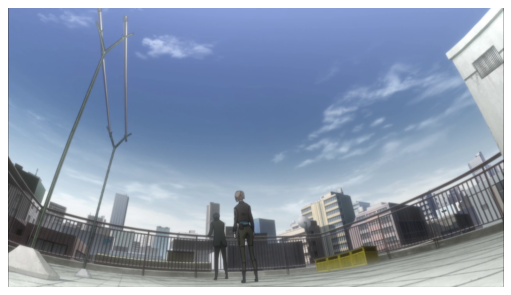

Exits: Down, Get into time machine
You see: 
Suzuha Amane
	 talk to suzuha
a phone
a dollar
another dollar
>take phone
You take the phone.
>examine phone
ON THE PHONE, YOU CAN SEE A NEWS PLAYING. A MIDDLE-AGE TIME MACHINE SCIENTIST SURVIVED AN AIRPLANE CRASH.
 HIS TIME MACHINE PAPER LUCKILY SURVIVED BECAUSE A METAL UPA (A SMALL TOY FROM GASHAPON MACHINE) IN HIS FOLDER WAS DETECTED AT THE SECURITY CHECK.
>talk to suzuha
Suzuha says, 'Kurisu is a genius scientist. You saw her in a blood pool on July 28th.
If you want to save her and change what has happened, you need to save her without changing what you yourself saw on that day.
Or else you will fail.
Remember how much you love her? Go back in time to deceive the world and save her!
Also, her dad uses the theory from her paper to invent the time machine and triggered WWIII.
To avoid WWIII, you need to destroy the paper. Now go!'
>take dollar
You take the dollar.
>take another dollar
You take the another dollar.
>down
A lab, a foundation

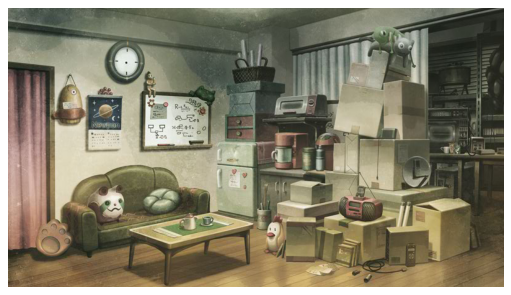

Exits: Up
You see: 
a lightsaber
a stun gun
a key
>take lightsaber
You take the lightsaber.
>take stun gun
You take the stun gun.
>examine lightsaber
A LIGHTSABER FILLED WITH RED FLUID
>take key
You take the key.
>up
You are standing on the roof. Your watch shows Aug 21.


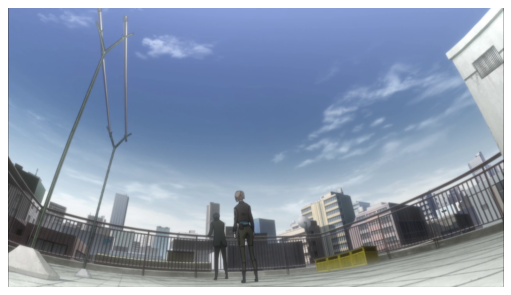

Exits: Down, Get into time machine
You see: 
Suzuha Amane
	 talk to suzuha
>get into time machine
The time machine invented by your lab partner in the future.


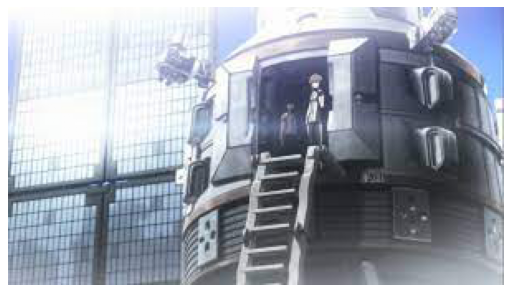

Exits: Time travel to august 21st, Time travel to july 28th
You see: 
a time line checker
	 check timeline (end game)
>time travel to july 28th
You are standing on the roof. Your watch shows Jul 28.


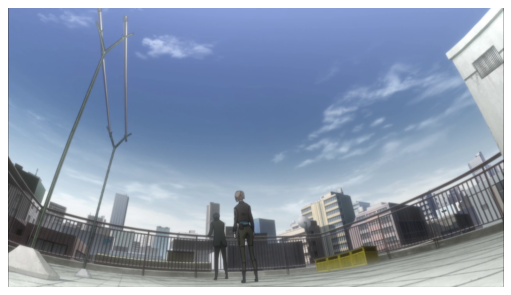

Exits: Get into time machine, In
You see: 
a locked door
	 unlock door
>unlock door
You unlock the door with the key.
The door opens into a landing with a few more stairs.
>in
You're walking in the stair. It's a bit dark here.
Exits: Out, Down
>down
You are in the 8th floor.


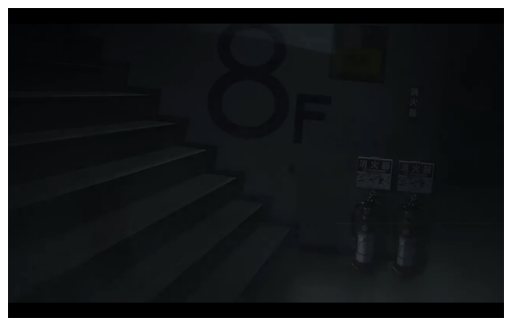

Exits: Up, Down, East
>down
You are in the 7th floor.


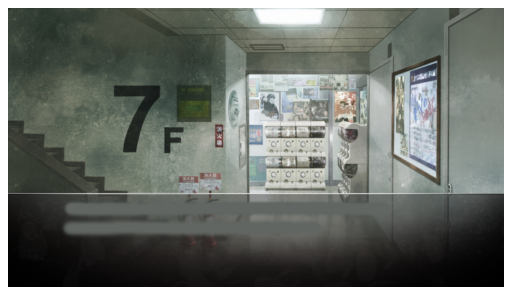

Exits: Up
You see: 
a gashapon machine whose next upa is metal
	 use gashapon machine
>use gashapon machine
You paid one dollar.
The next upa in the machine is metal
Now you have metal upa.
The next upa in the machine is plastic
>use gashapon machine
You paid one dollar.
Now you have plastic upa.
>up
You are in the 8th floor.


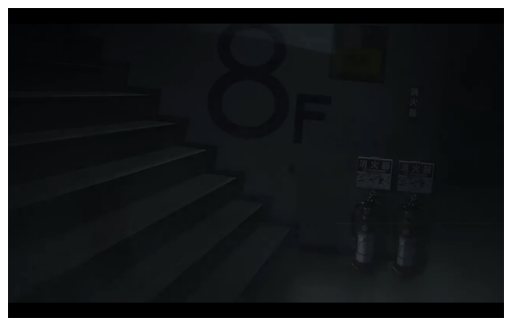

Exits: Up, Down, East
>east
A storage room, dark and wet. Kurisu's dad pushs Kurisu and grabs a folder that contains Kurisu's paper about time machine from her.
You can see a metal upa (a small metal toy) in the folder.
He waves a knife and threatens to kill Kurisu.


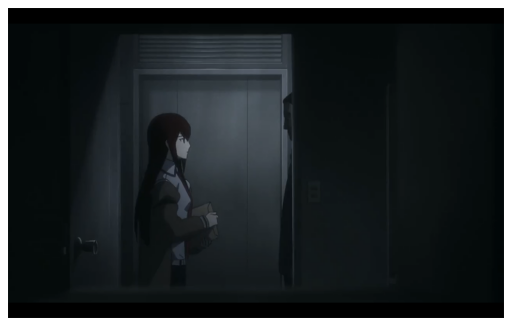

Exits: West
You see: 
Kurisu Makise
	 talk to kurisu
	 stun kurisu
	 use lightsaber
Kurisu's dad
	 hit kurisu's dad
	 stab kurisu's dad
	 scare kurisu's dad away
	 swap upa
	 talk to kurisu's dad
>talk to kurisu
Kurisu replies, 'You're the person I saw just now. Why are you here?'
>talk to kurisu's dad
Kurisu's dad replies, 'Oh the two of you are trying to conspire something against me!'
>hit kurisu's dad
You hit Kurisu's dad and his knife drops. You want to take the knife. 
After you have the knife, you can STAB KURISU'S DAD or SCARE KURISU'S DAD AWAY.
>swap upa
You put your plastic upa in his folder.

You put the metal upa taken from the folder into your pocket.
>take knife
You take the knife.
>scare kurisu's dad away
You waves the knife towards Kurisu's dad and he runs away.
>stun kurisu
'Hmmm....'
Kurisu lies down on the floor.
>use lightsaber
You open the lightsaber and pour red liquid inside onto her.
Kurisu soaks in the red liquid, as if she is soaked in blood.
You fake Kurisu's

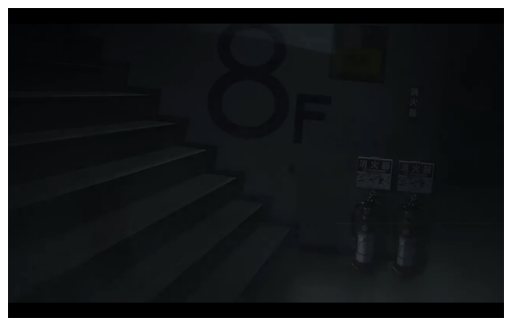

Exits: Up, Down, East
>up
You're walking in the stair. It's a bit dark here.
Exits: Out, Down
>out
You are standing on the roof. Your watch shows Jul 28.


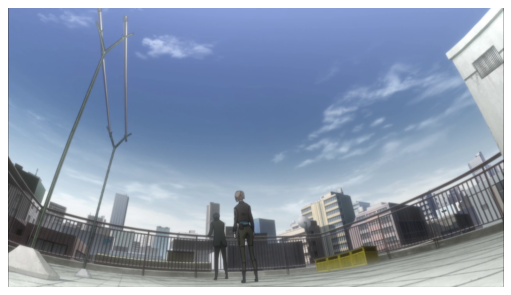

Exits: Get into time machine, In
You see: 
an unlocked door
>get into time machine
The time machine invented by your lab partner in the future.


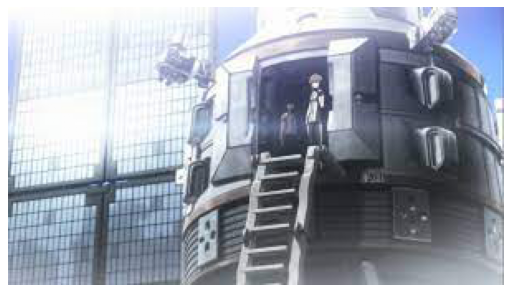

Exits: Time travel to august 21st, Time travel to july 28th
You see: 
a time line checker
	 check timeline (end game)
>check timeline (end game)
You activate the Steins Gate Timeline successfully! El Psy Kongroo!
THE GAME HAS ENDED.


In [93]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

game_loop()
print('THE GAME HAS ENDED.')

# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

In [98]:
# cloud_path = '/content/drive/My Drive/cis700-interactive-fic-and-text-gen/cis700-01-story/task2-stein-gate'
cloud_path = '/content/drive/My Drive/cis700-01-story/task2-stein-gate'
filename = 'game-visual'

The door is in this location.
Mounted at /content/drive/


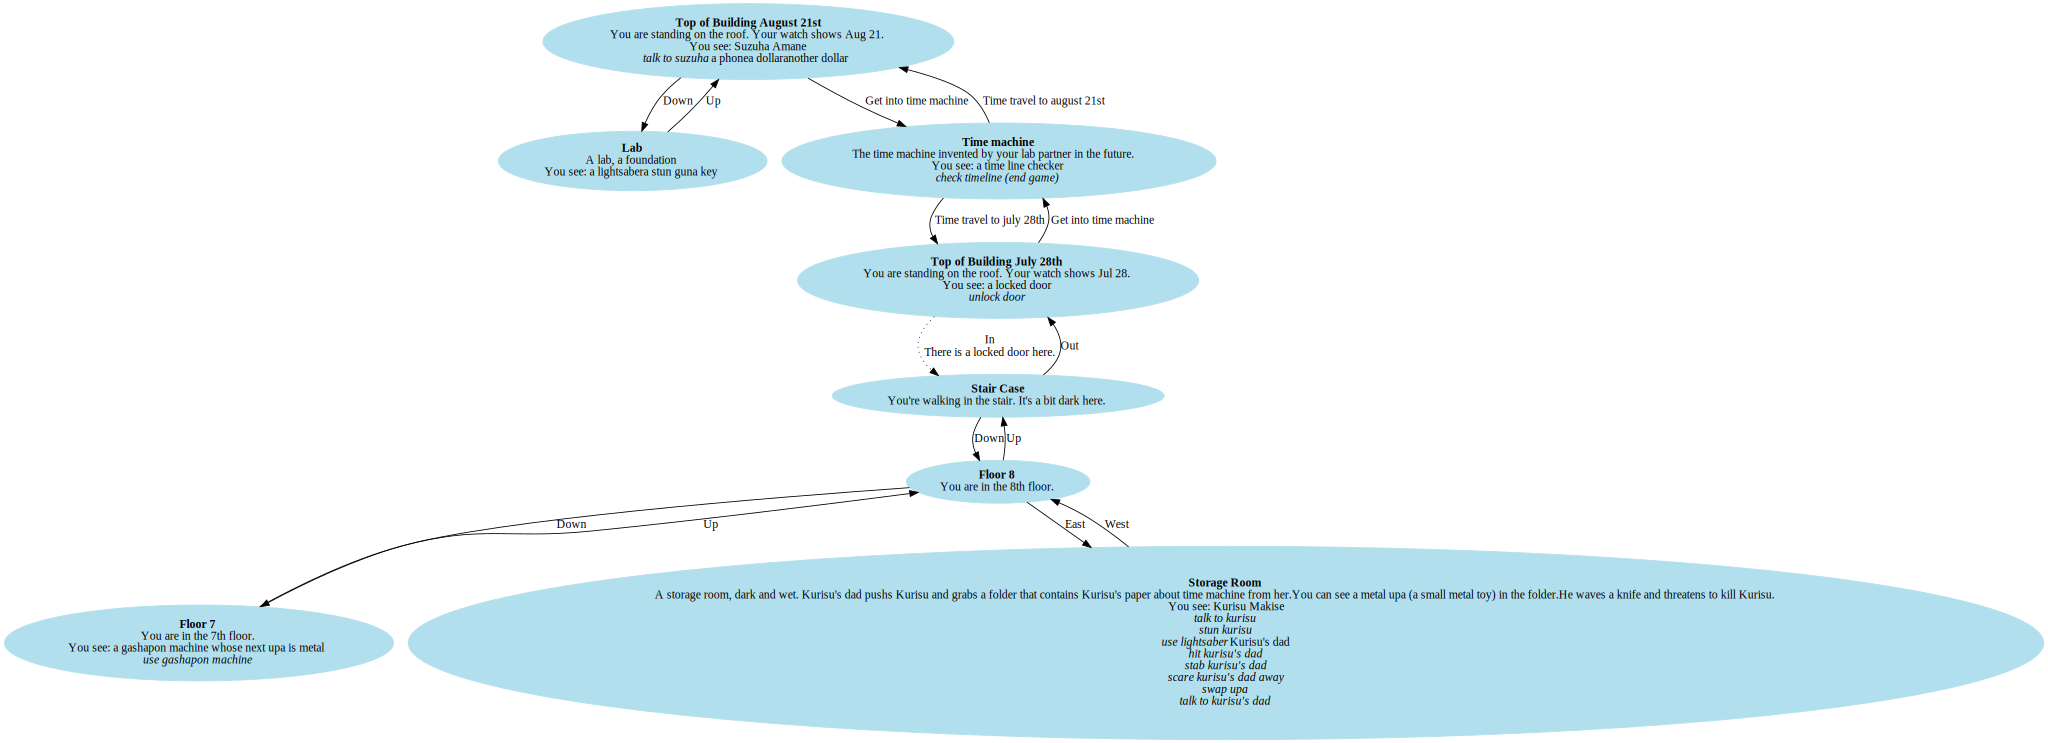

In [99]:
#@ title visualize the game by graph
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)
  graph.render(f'{cloud_path}/{filename}', view=True) 

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
save_to_drive(graph)
graph